In [36]:
'''
    This program is based on MNIST and DATA-LOADING tutorial in PyTorch.
    I have created MnistDataset class to read MNIST input csv files.
    This is a work for submission in
    Digit Recognizer of Kaggle Competition
    
    07/25/2017
    Oyashi
''' 

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from skimage import io, transform

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from PIL import Image, ImageOps

In [3]:
# Custom class to read training data

class MnistDataset(Dataset):
    """MNIST TRAIN DATASET"""

    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = np.asscalar(self.data.ix[idx, 0])
        image = self.data.ix[idx, 1:].as_matrix().astype('int8')
        image = image.reshape(28,28)
        image = Image.fromarray(image,mode='L')

        if self.transform:
            image = self.transform(image)

        return image,label

In [4]:
# Custom class to read testing data

class MnistDatasetTest(Dataset):
    """MNIST TEST DATASET"""

    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.ix[idx, 0:].as_matrix().astype('int8')
        image = image.reshape(28,28)
        image = Image.fromarray(image,mode='L')

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# Define transmorfation to be applied on images
transform = transforms.Compose(
    [transforms.Scale(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load training dataset
train_dataset = MnistDataset('input-files/train.csv', transform=transform)
trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

# Load testing dataset
test_dataset = MnistDatasetTest('input-files/test.csv', transform=transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [10]:
# Define classes of MNIST
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

# Helper function to show sample images
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Label:     2     9     1     7


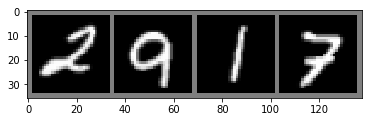

In [33]:
# Display sample training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Label:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

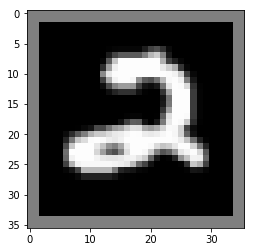

In [13]:
# Display sample testing data
test_dataiter = iter(testloader)
test_images = test_dataiter.next()

imshow(torchvision.utils.make_grid(test_images))

In [24]:
# Define network. This is LeNet

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Define loss. CrossEntropy loss is used here.
criterion = nn.CrossEntropyLoss()

# Define optimizer. Stochastic Gradient Descent is used here.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
# Start the training

all_losses = []
current_loss = 0.0

plot_every = 200

for epoch in range(4):
    print ('Training at epoch = ', epoch)
    current_loss = 0.0
    for i, data in enumerate(trainloader):
        # Read images and labels
        images, labels = data
        
        # Create Variable
        inputs, labels = Variable(images), Variable(labels)
        
        # Make gradient zero
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Print the current loss
        current_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, current_loss / plot_every))
            all_losses.append(current_loss / plot_every)
            current_loss = 0.0
            
            
print('Finished Training')

Training at epoch =  0
[1,  2000] loss: 11.330
[1,  4000] loss: 2.077
[1,  6000] loss: 1.126
[1,  8000] loss: 1.020
[1, 10000] loss: 0.834
Training at epoch =  1
[2,  2000] loss: 0.685
[2,  4000] loss: 0.697
[2,  6000] loss: 0.615
[2,  8000] loss: 0.536
[2, 10000] loss: 0.542
Training at epoch =  2
[3,  2000] loss: 0.432
[3,  4000] loss: 0.411
[3,  6000] loss: 0.432
[3,  8000] loss: 0.478
[3, 10000] loss: 0.447
Training at epoch =  3
[4,  2000] loss: 0.280
[4,  4000] loss: 0.398
[4,  6000] loss: 0.329
[4,  8000] loss: 0.322
[4, 10000] loss: 0.345
Finished Training


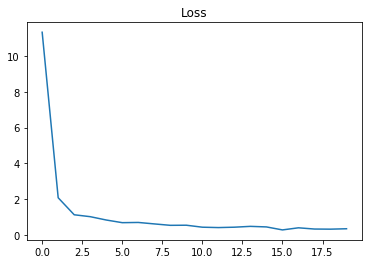

In [37]:
# Plot the loss graph
plt.figure()
plt.title('Loss figure')
plt.plot(all_losses)

Predicted Label:      2 


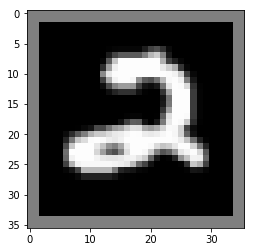

In [30]:
# Evaluating trained model with a single test data

dataiter = iter(testloader)
images = dataiter.next()

output = net(Variable(images))

_, predicted = torch.max(output.data, 1)

imshow(torchvision.utils.make_grid(images))
print('Predicted Label: ', ' '.join('%5s ' % classes[predicted[j][0]] for j in range(1) ))

In [29]:
# Evaluate all testing data and save the results

all_predictions = []

for i, data in enumerate(testloader):
    images = data
    output = net(Variable(images))
    _, predicted = torch.max(output.data, 1)
    all_predictions.append(classes[predicted[0][0]])

In [35]:
# Save the ImageId and Predicted Results into csv file

submission = pd.DataFrame({
        "ImageId": np.arange(1,len(all_predictions)+1),
        "Label": all_predictions
    })
submission.to_csv('mnist_results.csv', index=False)